### Libraries

In [1]:
! pip install stanza
! pip install hazm
! pip install clean-text[gpl]==0.4.0

In [2]:
import pandas as pd
import numpy as np
import stanza
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Load Data

In [3]:
PATH = 'data/'
PATH = PATH.rstrip('/')

In [4]:
df_train = pd.read_csv(PATH + '/train.csv')
df_train.columns = ['index', 'comment', 'rate']

df_eval = pd.read_csv(PATH + '/eval.csv')
df_eval.columns = ['index', 'comment', 'rate']

df_train.head(5)

,index,comment,rate
0,2587,پردازنده های Core i5 و Core i3 نیز ذاتا دو هست...,0.0
1,22591,سلام به دوستای عزیزم \r\nعزاداری هاتون قبول باشه,1.0
2,141037,کلا پولتون رو دور نریزیزد,-1.0
3,58593,از صمیم قلب امیدوارم دایانا با کارن بمونه و پو...,1.0
4,5712,آنطور که اپل ادعا می کند آیپاد شافل دارای طراح...,1.0


### Data Info

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    800 non-null    int64  
 1   comment  800 non-null    object 
 2   rate     800 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 18.9+ KB


In [6]:
df_train['rate'].describe()

count    800.000000
mean       0.278625
std        0.712302
min       -1.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: rate, dtype: float64

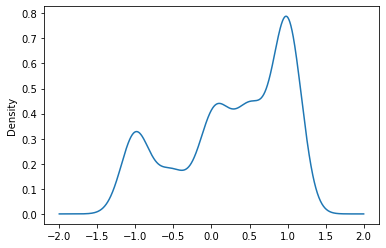

In [7]:
df_train['rate'].plot.kde()

### Cleaning

In [8]:
from hazm import *

#### Normalizer

In [9]:
example_id = 487

In [10]:
example = df_train['comment'][example_id]
example

'پسندیدم'

In [11]:
normalizer = Normalizer()
df_train['comment'] = df_train['comment'].apply(lambda comment:normalizer.normalize(comment))
df_eval['comment'] = df_eval['comment'].apply(lambda comment:normalizer.normalize(comment))

**After Normalization**

In [12]:
example = df_train['comment'][example_id]
example

'پسندیدم'

#### Clean Text

In [13]:
from cleantext import clean

In [14]:
clean_comment = lambda comment: clean(comment, 
                                      fix_unicode=True,
                                      to_ascii=False,
                                      lower=True,
                                      no_line_breaks=True,
                                      no_urls=True,
                                      no_emails=True,
                                      no_phone_numbers=True,
                                      no_numbers=False,
                                      no_digits=False,
                                      no_currency_symbols=True,
                                      no_punct=False)

In [15]:
df_train['clean_comment'] = df_train['comment'].apply(lambda comment:clean_comment(comment))
df_eval['clean_comment'] = df_eval['comment'].apply(lambda comment:clean_comment(comment))

In [16]:
example = df_train['clean_comment'][example_id]
example

'پسندیدم'

#### Tokenize with Hazm

In [17]:
df_train['clean_comment'] = df_train['comment'].apply(lambda comment:word_tokenize(comment))
df_eval['clean_comment'] = df_eval['comment'].apply(lambda comment:word_tokenize(comment))

#### Remove Stopwords

In [18]:
import re

In [19]:
stopwords = utils.stopwords_list()
stop_pattern = r"\b(?:" + "|".join(map(re.escape, stopwords)) + r")\b"
stop_regex = re.compile(stop_pattern).pattern

In [20]:
clean_stopwords = lambda comment:[word for word in comment if re.sub(stop_regex, "", word)!=""]

In [21]:
df_train['clean_comment'] = df_train['clean_comment'].apply(lambda comment:clean_stopwords(comment))
df_eval['clean_comment'] = df_eval['clean_comment'].apply(lambda comment:clean_stopwords(comment))

In [22]:
example = df_train['clean_comment'][example_id]
example

['پسندیدم']

#### Remove Symbols

In [23]:
symbol_patterns = r"(\d|\"|'ٍ|¬|[؛“،,”‘۔’’‘–]|[|\.÷+\:\-\?»\=\{}\*«»_…\؟!/ـ]|[۰'ٓ۫'ٔ]|[ٓٔ]|[ًٌٍْﹼ،َُِّ«ٰ»ٖء])"
symbol_regex = re.compile(symbol_patterns).pattern

In [24]:
clean_symbols = lambda comment:[word for word in comment if re.sub(symbol_regex, "", word)!=""]

In [25]:
df_train['clean_comment'] = df_train['clean_comment'].apply(lambda comment:clean_symbols(comment))
df_eval['clean_comment'] = df_eval['clean_comment'].apply(lambda comment:clean_symbols(comment))

#### Remove Wierd Symbols

In [26]:
# removing wierd patterns
wierd_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u'\U00010000-\U0010ffff'
    u"\u200d"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\u3030"
    u"\ufe0f"
    u"\u2069"
    u"\u2066"
    # u"\u200c"
    u"\u2068"
    u"\u2067"
    "]+", flags=re.UNICODE)
    
wierd_regex = re.compile(wierd_pattern).pattern

In [27]:
clean_wierds = lambda comment:[word for word in comment if re.sub(wierd_regex, "", word)!=""]

In [28]:
df_train['clean_comment'] = df_train['clean_comment'].apply(lambda comment:clean_symbols(comment))
df_eval['clean_comment'] = df_eval['clean_comment'].apply(lambda comment:clean_symbols(comment))

In [29]:
example = df_train['clean_comment'][example_id]
example

['پسندیدم']

#### Remove English Tokens

In [30]:
english_words_pattern = r"[A-Za-z]"
english_words_regex = re.compile(english_words_pattern).pattern

In [31]:
clean_english_words = lambda comment:[re.sub(english_words_regex, "", word) for word in comment if re.sub(english_words_regex, "", word)!=""]

In [32]:
df_train['clean_comment'] = df_train['clean_comment'].apply(lambda comment:clean_english_words(comment))
df_eval['clean_comment'] = df_eval['clean_comment'].apply(lambda comment:clean_english_words(comment))

#### Remove Spaces

In [33]:
space_pattern = r"[\xad\ufeff\u200e\u200d\u200b\x7f\u202a\u2003\xa0\u206e\u200c\x9d]"
space_regex = re.compile(space_pattern).pattern

In [34]:
clean_spaces = lambda comment:[re.sub(symbol_regex, "", word) for word in comment if re.sub(symbol_regex, "", word)!=""]

In [35]:
df_train['clean_comment'] = df_train['clean_comment'].apply(lambda comment:clean_spaces(comment))
df_eval['clean_comment'] = df_eval['clean_comment'].apply(lambda comment:clean_spaces(comment))

In [36]:
example = df_train['clean_comment'][example_id]
example

['پسندیدم']

#### Stemming

In [37]:
stem = Stemmer().stem
clean_stem = lambda comment:[stem(word) for word in comment]

In [38]:
df_train['clean_comment'] = df_train['clean_comment'].apply(lambda comment:clean_stem(comment))
df_eval['clean_comment'] = df_eval['clean_comment'].apply(lambda comment:clean_stem(comment))

In [39]:
example = df_train['clean_comment'][example_id]
example

['پسندید']

#### Delete Empty Comments

In [40]:
indices = df_train.index[df_train["clean_comment"].str.len() != 0].tolist()
df_train = df_train.iloc[indices].reset_index(drop=True)

#### Label rates

In [58]:
def rate_to_label(rate, threshold=0.0):
    if rate <= threshold:
        return 'negative'
    else:
        return 'positive'


df_train['label'] = df_train['rate'].apply(lambda t: rate_to_label(t))
df_eval['label'] = df_eval['rate'].apply(lambda t: rate_to_label(t))

### More about comments

In [42]:
min_max_len = df_train["clean_comment"].str.len().min(), df_train["clean_comment"].str.len().max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 1 	Max: 330


In [43]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_train["clean_comment"].str.len()
))

fig.update_layout(
    title_text='Distribution of word counts within comments',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

#### Unbalanced Data

In [44]:
fig = go.Figure()

groupby_label = df_train.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### Balance Data

In [45]:
negative_data = df_train[df_train['label'] == 'negative']
positive_data = df_train[df_train['label'] == 'positive']

cutting_point = min(len(negative_data), len(positive_data))

if cutting_point <= len(negative_data):
    negative_data = negative_data.sample(n=cutting_point).reset_index(drop=True)

if cutting_point <= len(positive_data):
    positive_data = positive_data.sample(n=cutting_point).reset_index(drop=True)

balanced_data = pd.concat([negative_data, positive_data])
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          592 non-null    int64  
 1   comment        592 non-null    object 
 2   rate           592 non-null    float64
 3   clean_comment  592 non-null    object 
 4   label          592 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 23.2+ KB


In [46]:
fig = go.Figure()

groupby_label = balanced_data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [47]:
balanced_data

,index,comment,rate,clean_comment,label
0,1547,فقط دوتا مورد داره که اونم در کنار این همه نکت...,0.0,"[دوتا, داره, اون, نکته, مثب, میگ, کسا, می‌خو, ...",negative
1,1739,One Plus نیز همانند مدل پیشین گوشی‌های Sensati...,0.0,"[همانند, مدل, پیشین, گوشی, سیس, صوت, بهره, می‌...",negative
2,4306,با عرض سلام و خسته نباشی به دست اندرکاران دیجی...,0.0,"[عرض, سلا, خسته, نباش, دس, اندرکار, دیج, کالا]",negative
3,30698,دوسش داشتم♥️جذابه،,0.2,"[دوس, داشتم♥️جذابه]",positive
4,44162,سیب زمینیش واقعا بده از نظر مقدار و کیفیت و اص...,1.0,"[سیب, زمین, واقعا, بده, مقدار, کیف, اصلا, ارز,...",positive
...,...,...,...,...,...
587,35,البته بعد از آی پد ۲و۳و۴,0.0,"[آ, پد, وو]",negative
588,13383,شکل بعضی دکمه‌ها هم تغییر کرده است تا با نمایش...,0.0,"[شکل, دکمه, نمایشگر, چرخنده, منطبق]",negative
589,610,امیدوارم در راهی که طی می‌کنید همیشه موفق باشید.,0.0,"[امیدوار, راه, می‌کنید, موفق, باشید]",negative
590,105136,اسپیگن یکی از شاخ‌های بازاره من خریدم برای همس...,1.0,"[اسپیگن, شاخ, بازاره, خرید, همسر, منتظر, برسه]",positive


#### Concat Cleaned Tokens

In [48]:
balanced_data['cat_clean_comment'] = balanced_data['clean_comment'].apply(lambda comment:" ".join(comment))
df_eval['cat_clean_comment'] = df_eval['clean_comment'].apply(lambda comment:" ".join(comment))

## TFIDF Classifier

In [49]:
balanced_data

,index,comment,rate,clean_comment,label,cat_clean_comment
0,1547,فقط دوتا مورد داره که اونم در کنار این همه نکت...,0.0,"[دوتا, داره, اون, نکته, مثب, میگ, کسا, می‌خو, ...",negative,دوتا داره اون نکته مثب میگ کسا می‌خو بخرن بدونن
1,1739,One Plus نیز همانند مدل پیشین گوشی‌های Sensati...,0.0,"[همانند, مدل, پیشین, گوشی, سیس, صوت, بهره, می‌...",negative,همانند مدل پیشین گوشی سیس صوت بهره می‌برد خلاف...
2,4306,با عرض سلام و خسته نباشی به دست اندرکاران دیجی...,0.0,"[عرض, سلا, خسته, نباش, دس, اندرکار, دیج, کالا]",negative,عرض سلا خسته نباش دس اندرکار دیج کالا
3,30698,دوسش داشتم♥️جذابه،,0.2,"[دوس, داشتم♥️جذابه]",positive,دوس داشتم♥️جذابه
4,44162,سیب زمینیش واقعا بده از نظر مقدار و کیفیت و اص...,1.0,"[سیب, زمین, واقعا, بده, مقدار, کیف, اصلا, ارز,...",positive,سیب زمین واقعا بده مقدار کیف اصلا ارز خرید نداره
...,...,...,...,...,...,...
587,35,البته بعد از آی پد ۲و۳و۴,0.0,"[آ, پد, وو]",negative,آ پد وو
588,13383,شکل بعضی دکمه‌ها هم تغییر کرده است تا با نمایش...,0.0,"[شکل, دکمه, نمایشگر, چرخنده, منطبق]",negative,شکل دکمه نمایشگر چرخنده منطبق
589,610,امیدوارم در راهی که طی می‌کنید همیشه موفق باشید.,0.0,"[امیدوار, راه, می‌کنید, موفق, باشید]",negative,امیدوار راه می‌کنید موفق باشید
590,105136,اسپیگن یکی از شاخ‌های بازاره من خریدم برای همس...,1.0,"[اسپیگن, شاخ, بازاره, خرید, همسر, منتظر, برسه]",positive,اسپیگن شاخ بازاره خرید همسر منتظر برسه


In [50]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=1, max_df =0.95, ngram_range = (1,1), max_features=10000)

train_data_features = vectorizer.fit_transform(balanced_data['cat_clean_comment'])

print(train_data_features.shape)

(592, 2490)


#### Data snooping ALERT: we should transforom not fit again

In [52]:
eval_data_features = vectorizer.transform(df_eval['cat_clean_comment'])

#### Feature Names

In [53]:
vectorizer.get_feature_names()[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['آب', 'آبرو', 'آبمیوه', 'آبک', 'آثار', 'آجر', 'آخر', 'آخه', 'آد', 'آداب']

In [65]:
# Load model

solvers= ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
multi_classes = ['multinomial', 'ovr']

model = LogisticRegression(penalty='l2', random_state=0, solver='lbfgs', max_iter=1000, multi_class='ovr')
# Train model
model.fit(train_data_features, balanced_data['label'])


LogisticRegression(max_iter=1000, multi_class='ovr', random_state=0)

### evaluation 

In [56]:
y_eval_perd = model.predict(eval_data_features)

#### Accuracy Score

In [62]:
print(accuracy_score(df_eval['label'], y_eval_perd))

0.57


#### Confusion Matrix

In [63]:
print(confusion_matrix(df_eval['label'], y_eval_perd))

[[48 37]
 [49 66]]


#### Classification Report

In [64]:
print(classification_report(df_eval['label'], y_eval_perd))

              precision    recall  f1-score   support

    negative       0.49      0.56      0.53        85
    positive       0.64      0.57      0.61       115

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.58      0.57      0.57       200



## Bert Classifier

In [ ]:
!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]